In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset

import re
import pandas as pd
import numpy as np

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import zipfile
from tqdm import tqdm
from google.colab import drive

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
stem = SnowballStemmer('english')
lemma = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

MessageError: ignored

### Функции

#### 1 Задание

In [ ]:
def preprocess_text(text: str):
  text = (re.sub(r"([\d,!?'/:])", "", text)).lower()
  return text

In [ ]:
def create_binominal_tensor(text, n=0):
  vocab = list(dict.fromkeys([word for word in word_tokenize(text)]))
  sentence = text.split('.')[n]
  print(sentence)
  return ([1 if word in sentence else 0 for word in vocab])

In [ ]:
def create_unitarian_tensor(text, n=0):
  vocab = list(dict.fromkeys([word for word in word_tokenize(text)]))
  sentence = text.split('.')[n].split()
  result = []
  for s_word in sentence:
    preresult = []
    for v_word in vocab:
      preresult.append(1) if s_word == v_word else preresult.append(0)
    result.append(preresult)
  return result

In [ ]:
def cleanalyzer(text):
    text = (re.sub(r'\d+', '', text)).lower()
    text = word_tokenize(text)
    text = [lemma.lemmatize(word) for word in text if word not in stop_words]
    text = [word for word in text if len(word) > 2 and len(word) < 30]
    text = [stem.stem(word) for word in text]
    text = ' '.join(text)
    return text

In [ ]:
def token_to_index(text, split=False):
  return {word: index for index, word in enumerate(text.split())} if split else {word: index for index, word in enumerate(text)}

In [ ]:
def index_to_token(text, split=False):
  return {index: word for index, word in enumerate(text.split())} if split else {index: word for index, word in enumerate(text).split()}

#### 2 Задание

In [ ]:
class SurnamesVocab:
    def __init__(self, data):
        self.idx_to_token = {0:"<PAD>"}
        self.token_to_idx = {"<PAD>":0}
        self.max_seq_len = 0
        self.gennerate_vocab(data)
        self.vocab_len = len(self.token_to_idx)

    def add_token(self, token):
        if token not in self.token_to_idx:
            self.token_to_idx[token] = len(self.token_to_idx)
            self.idx_to_token[len(self.idx_to_token)] = token

    def gennerate_vocab(self, data):
        for surname in data:
          if len(surname) > self.max_seq_len:
            self.max_seq_len = len(surname)
          for char in preprocess_text(surname):
            self.add_token(char)

In [ ]:
class SurnamesDataset():
    def __init__(self, x, y, _vocab: SurnamesVocab):
        self.x = x
        self.y = y
        self.vocab = _vocab

    def vectorize(self, _surname: str):
        output_vector = [0 for _ in range(vocab.max_seq_len)]
        _surname = preprocess_text(_surname)
        for l in range(len(_surname)):
            output_vector[vocab.max_seq_len - len(_surname) + l] = self.vocab.token_to_idx[_surname[l]]

        return torch.FloatTensor(output_vector)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.vectorize(self.x.iloc[idx]).long(), torch.tensor(nationality_to_idx[self.y.iloc[idx]])

In [ ]:
def tokenize_surname(_surname: str) -> torch.LongTensor:
    dataset = SurnamesDataset(None, None, vocab)
    return dataset.vectorize(_surname).reshape(1, vocab.max_seq_len).long()

In [ ]:
def check_surnames(surnames, model, dataset, nationalities):
  for surname in surnames:
    preds = model(tokenize_surname(surname).to(device)).topk(3).indices.flatten()
    pred_nationalities = [idx_to_nationalities[int(pred)] for pred in preds]
    print(f'{surname.capitalize():>10} \t PREDICTED: {pred_nationalities}')

#### 3 Задание

In [ ]:
class Vocab:
    def __init__(self, data, unk_token: str = "<UNK>"):
        self.max_seq_len = 0
        tokens = set()
        for item in data:
            words = [word for word in word_tokenize(self.preprocess_text(item))]
            if len(words) > self.max_seq_len:
                self.max_seq_len = len(words)
            tokens.update(words)
        if unk_token is not None:
            tokens.add(unk_token)
        self.idx_to_token = dict(enumerate(tokens, 1))
        self.idx_to_token[0] = "<PAD>"
        self.token_to_idx = {token: idx for idx, token in self.idx_to_token.items()}
        self.vocab_len = len(self.idx_to_token)

    def preprocess_text(self, text):
        return re.sub(r"[^a-zA-Z,!?\.]", " ", text.lower())

In [ ]:
class ReviewsDataset(Dataset):
    def __init__(self, X, y, vocab):
        self.X = X
        self.y = y
        self.vocab = vocab

    def to_indices(self, review):
        seq = [
            self.vocab.token_to_idx[token]
            if token in self.vocab.token_to_idx.keys()
            else self.vocab.token_to_idx["<PAD>"]
            for token in word_tokenize(review)
        ]
        if len(seq) < self.vocab.max_seq_len:
            seq.extend([self.vocab.token_to_idx["<PAD>"]] * (self.vocab.max_seq_len - len(seq)))
        else:
            seq = seq[: self.vocab.max_seq_len]
        return torch.LongTensor(seq)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.to_indices(self.X[idx]), self.y[idx]

In [ ]:
def review_rating(reviews_list, targets_dict):
  for review, target in zip(reviews_list, list(targets_dict.values())):
    x = train_dataset.to_indices(review).unsqueeze(0)
    predictions = model(x.to(device)).argmax(dim=1).cpu().detach()
    predictions_str = targets_dict[predictions.item()]

    print(f"Review: \n{review[:100]}..")
    print(f"True    : {target}")
    print(f"Predicts: {predictions}")
    print(f"Predicts string: {predictions_str}\n")

#### Общие функции

In [ ]:
def train(dataloader, model, loss_fn, optimizer, epoch, reshape=False):
    size = len(dataloader.dataset)
    model.train()
    loss_sum = 0

    total_samples = 0.0
    correct_samples = 0.0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        if reshape:
          X = X.reshape(-1, 17*52)
        pred = model(X.type(torch.long))
        # torch.max(y, 1)[1]
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum += loss

        total_samples += y.shape[0]
        _, prediction_indices = torch.max(pred, 1)
        correct_samples += torch.sum(prediction_indices==y)

    if epoch == 0 or (epoch+1)%5 == 0:
        print(f"train loss: {loss.item():>7f}")
    return float(correct_samples) / total_samples, (loss_sum / len(dataloader)).cpu().detach().numpy()

In [ ]:
def test(dataloader, model, loss_fn, epoch):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.eval()

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    if epoch == 0 or (epoch+1)%5 == 0:
      print(f"test: accuracy: {(100*correct):>0.1f}%, val loss: {test_loss:>8f} \n")
    return correct, test_loss

In [ ]:
def train_test(train_dl, test_dl, model, loss_fn, optimizer, epochs=10, reshape=False):
  history = pd.DataFrame(columns=['epoch', 'train loss', 'train accuracy', 'val loss', 'test accuracy'])
  for epoch in range(epochs):
      if epoch == 0 or (epoch+1)%5 == 0:
        print(f"Epoch {epoch+1}:")
      train_acc, train_loss = train(train_dl, model, loss_fn, optimizer, epoch, reshape)
      test_acc, val_loss = test(test_dl, model, loss_fn, epoch)
      history.loc[epoch] = [epoch, train_loss, train_acc, val_loss, test_acc]
  return model, history

In [ ]:
def train_test_info(history):
  fig, _axs = plt.subplots(nrows=2, figsize=(10, 10))
  axs = _axs.flatten()
  axs[0].plot(history['train loss'], label='Train loss')
  axs[0].plot(history['val loss'], label='Val loss')
  axs[0].legend(frameon=False);
  axs[1].plot(history['train accuracy'], label='Train accuracy')
  axs[1].plot(history['test accuracy'], label='Test accuracy')
  axs[1].legend(frameon=False)
  plt.show()

In [ ]:
def conf_mat(model, test_dl, classes):
  model.eval()
  true = torch.empty(0).to(device)
  predict = torch.empty(0).to(device)

  with torch.no_grad():
    for inputs, targets in test_dl:
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs.view(inputs.shape[0], -1)

        outputs = model(inputs)

        _, predictions_indices = torch.max(outputs, 1)

        true = torch.cat((true, targets))
        predict = torch.cat((predict, predictions_indices))

  plt.figure(figsize=(15,15))
  sns.heatmap(
    pd.DataFrame(
        confusion_matrix(true.cpu().numpy().astype("int"), predict.cpu().numpy().astype("int")),
    ),
    annot=True,
    fmt="d",
    xticklabels=classes,
    yticklabels=classes
  );

  total_accuracy = torch.sum(true==predict) / true.shape[0]
  print(f"total accuracy: {total_accuracy:.3f}")

## 1. Представление и предобработка текстовых данных в виде последовательностей

1.1 Представьте первое предложение из строки `text` как последовательность из индексов слов, входящих в это предложение

In [ ]:
text = 'Select your preferences and run the install command. Stable represents the most currently tested and supported version of PyTorch. Note that LibTorch is only available for C++'

In [ ]:
text = preprocess_text(text)
create_binominal_tensor(text)

select your preferences and run the install command


[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

1.2 Представьте первое предложение из строки `text` как последовательность векторов, соответствующих индексам слов. Для представления индекса в виде вектора используйте унитарное кодирование. В результате должен получиться двумерный тензор размера `количество слов в предложении` x `количество уникальных слов`

In [ ]:
for string in create_unitarian_tensor(text):
  print(string)

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
(len(create_unitarian_tensor(text)), len(create_unitarian_tensor(text)[0]))

(8, 26)

1.3 Решите задачу 1.2, используя модуль `nn.Embedding`

In [ ]:
first = str(text.split('.')[0])
first

'select your preferences and run the install command'

In [ ]:
token_to_index(first, True)

{'select': 0,
 'your': 1,
 'preferences': 2,
 'and': 3,
 'run': 4,
 'the': 5,
 'install': 6,
 'command': 7}

In [ ]:
embedding = nn.Embedding(26, 26)
lookup_tensor = torch.tensor(list(token_to_index(first, True).values()), dtype=torch.long)
embedded = embedding(lookup_tensor)
embedded.shape

torch.Size([8, 26])

In [ ]:
embedded

tensor([[ 0.0553,  0.1279,  0.8791,  1.7244,  0.0873, -1.1014,  0.4836, -0.0885,
         -1.1780,  0.9308,  0.1438,  0.5666,  0.1707,  0.5928,  0.6243,  1.2052,
         -2.7547,  0.2620,  0.4250, -0.1320,  0.7179,  0.2987, -0.6656, -0.9995,
         -1.2190,  2.6526],
        [-1.1633, -1.2288, -0.8088,  2.0148, -1.0588,  0.0502,  0.7462,  0.2396,
          0.1541, -1.2595,  1.0103, -1.5988, -0.0319,  0.3284, -1.8774,  0.9228,
         -1.0651,  0.6710,  1.5679, -0.7496, -0.7499, -0.9579,  1.3986,  0.7300,
          0.4013, -1.2258],
        [ 0.9649, -0.9177, -0.5505, -1.2681, -0.6863, -1.0424, -0.0956, -2.2478,
          0.0089, -1.4720, -0.9789,  1.1017, -1.2449,  0.3367,  0.1436, -1.9720,
          0.1599, -0.2369,  0.1762,  1.2517,  0.1619,  1.5908, -0.1720, -0.5884,
         -1.0092, -0.2857],
        [ 0.4050, -1.0540, -0.1729, -1.7146,  1.2919, -1.1733,  1.3594, -0.4930,
         -0.9209,  1.6763,  2.0287, -0.5257,  1.4961,  0.7374, -1.7667, -0.8181,
          0.8388, -0.2208

In [ ]:
weights = torch.eye(8, 26).to(device)
embedding2 = nn.Embedding(27, 8)
embedding2.weight = torch.nn.Parameter(weights)
embedding2(lookup_tensor.to(device))

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0'

## 2. Классификация фамилий по национальности (ConvNet)

Датасет: https://disk.yandex.ru/d/owHew8hzPc7X9Q?w=1

2.1 Считать файл `surnames/surnames.csv`.

2.2 Закодировать национальности числами, начиная с 0.

2.3 Разбить датасет на обучающую и тестовую выборку

2.4 Реализовать класс `Vocab` (токен = __символ__)
  * добавьте в словарь специальный токен `<PAD>` с индексом 0
  * при создании словаря сохраните длину самой длинной последовательности из набора данных в виде атрибута `max_seq_len`

2.5 Реализовать класс `SurnamesDataset`
  * метод `__getitem__` возвращает пару: <последовательность индексов токенов (см. 1.1 ), номер класса>
  * длина каждой такой последовательности должна быть одинаковой и равной `vocab.max_seq_len`. Чтобы добиться этого, дополните последовательность справа индексом токена `<PAD>` до нужной длины

2.6. Обучить классификатор.
  
  * Для преобразования последовательности индексов в последовательность векторов используйте `nn.Embedding`. Рассмотрите два варианта:
    - когда токен представляется в виде унитарного вектора и модуль `nn.Embedding` не обучается
    - когда токен представляется в виде вектора небольшой размерности (меньше, чем размер словаря) и модуль `nn.Embedding` обучается

  * Используйте одномерные свертки и пулинг (`nn.Conv1d`, `nn.MaxPool1d`)
    - обратите внимание, что `nn.Conv1d` ожидает на вход трехмерный тензор размерности `(batch, embedding_dim, seq_len)`

2.7 Измерить точность на тестовой выборке. Проверить работоспособность модели: прогнать несколько фамилий студентов группы через модели и проверить результат. Для каждой фамилии выводить 3 наиболее вероятных предсказания.

2.1 Считать файл surnames/surnames.csv.

In [ ]:
zf = zipfile.ZipFile('drive/MyDrive/datasets/surnames.zip')
for file in tqdm(zf.infolist()):
    zf.extract(file)

100%|██████████| 2/2 [00:00<00:00, 621.61it/s]


In [ ]:
df = pd.read_csv("/content/surnames/surnames.csv")
df.head()

,surname,nationality
0,Woodford,English
1,Coté,French
2,Kore,English
3,Koury,Arabic
4,Lebzak,Russian


2.2 Закодировать национальности числами, начиная с 0.

In [ ]:
nationalities = {nationality: index for index, nationality in enumerate(df["nationality"].unique())}
nationality_to_idx = dict(zip(nationalities, range(len(nationalities))))
idx_to_nationalities = {v: u for u, v in nationality_to_idx.items()}
df["index"] = df["nationality"].map(nationalities)
targets = torch.tensor(df["index"])
df.head()

,surname,nationality,index
0,Woodford,English,0
1,Coté,French,1
2,Kore,English,0
3,Koury,Arabic,2
4,Lebzak,Russian,3


In [ ]:
print(f'Количество классов: {len(set(df["index"].unique()))}')

Количество классов: 18


2.4 Реализовать класс `Vocab` (токен = __символ__)
  * добавьте в словарь специальный токен `<PAD>` с индексом 0
  * при создании словаря сохраните длину самой длинной последовательности из набора данных в виде атрибута `max_seq_len`

In [ ]:
vocab = SurnamesVocab(df["surname"])
vocab.max_seq_len

17

In [ ]:
targets

tensor([ 0,  1,  0,  ..., 12,  0,  9])

In [ ]:
vocab.vocab_len

52

2.3 Разбить датасет на обучающую и тестовую выборку\
2.5 Реализовать класс `SurnamesDataset`
  * метод `__getitem__` возвращает пару: <последовательность индексов токенов (см. 1.1 ), номер класса>
  * длина каждой такой последовательности должна быть одинаковой и равной `vocab.max_seq_len`. Чтобы добиться этого, дополните последовательность справа индексом токена `<PAD>` до нужной длины


In [ ]:
surnames_train, surnames_test = train_test_split(df, test_size=0.2)

train_dataset = SurnamesDataset(surnames_train["surname"], surnames_train["nationality"], vocab)
test_dataset = SurnamesDataset(surnames_test["surname"], surnames_test["nationality"], vocab)

trainloader = torch.utils.data.DataLoader(train_dataset)
testloader = torch.utils.data.DataLoader(test_dataset)

classes = df["nationality"].unique()
print(f'dataset size: {len(train_dataset)+len(test_dataset)}\n'+
      f'train size: {len(train_dataset)}\ntest size: {len(test_dataset)}')

dataset size: 10980
train size: 8784
test size: 2196


2.6. Обучить классификатор.
  
  * Для преобразования последовательности индексов в последовательность векторов используйте `nn.Embedding`. Рассмотрите два варианта:
    - когда токен представляется в виде унитарного вектора и модуль `nn.Embedding` не обучается
    - когда токен представляется в виде вектора небольшой размерности (меньше, чем размер словаря) и модуль `nn.Embedding` обучается

  * Используйте одномерные свертки и пулинг (`nn.Conv1d`, `nn.MaxPool1d`)
    - обратите внимание, что `nn.Conv1d` ожидает на вход трехмерный тензор размерности `(batch, embedding_dim, seq_len)`

##### Токен представляется в виде унитарного вектора и модуль nn.Embedding не обучается

In [ ]:
unitarian_model = nn.Sequential(
    nn.Embedding(vocab.vocab_len, vocab.vocab_len),

    nn.Conv1d(vocab.max_seq_len, 32, 3),
    nn.MaxPool1d(2),
    nn.LeakyReLU(0.1),

    nn.Conv1d(32, 64, 3),
    nn.MaxPool1d(2),
    nn.LeakyReLU(0.1),

    nn.Dropout(0.5),
    nn.Flatten(),
    nn.Linear(704, 512),
    nn.Dropout(0.5),
    nn.LeakyReLU(0.1),
    nn.Linear(512, len(nationality_to_idx))
).to(device)


list(unitarian_model[0].parameters())[0].data = torch.eye(vocab.vocab_len, vocab.vocab_len).to(device)
list(unitarian_model[0].parameters())[0].requires_grad = False

unitarian_model(next(iter(trainloader))[0].to(device)).shape

torch.Size([1, 18])

In [ ]:
list(unitarian_model[0].parameters())[0].data

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]], device='cuda:0')

In [ ]:
optimizer = torch.optim.Adam(unitarian_model.parameters(), weight_decay=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
unitarian_model, history = train_test(trainloader, testloader, unitarian_model, criterion, optimizer, 10)

Epoch 1:
train loss: 1.127400
test: accuracy: 60.1%, val loss: 1.394871 

Epoch 5:
train loss: 0.130834
test: accuracy: 66.2%, val loss: 1.151603 

Epoch 10:
train loss: 0.509614
test: accuracy: 66.7%, val loss: 1.097776 



In [ ]:
list(unitarian_model[0].parameters())[0].data

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]], device='cuda:0')

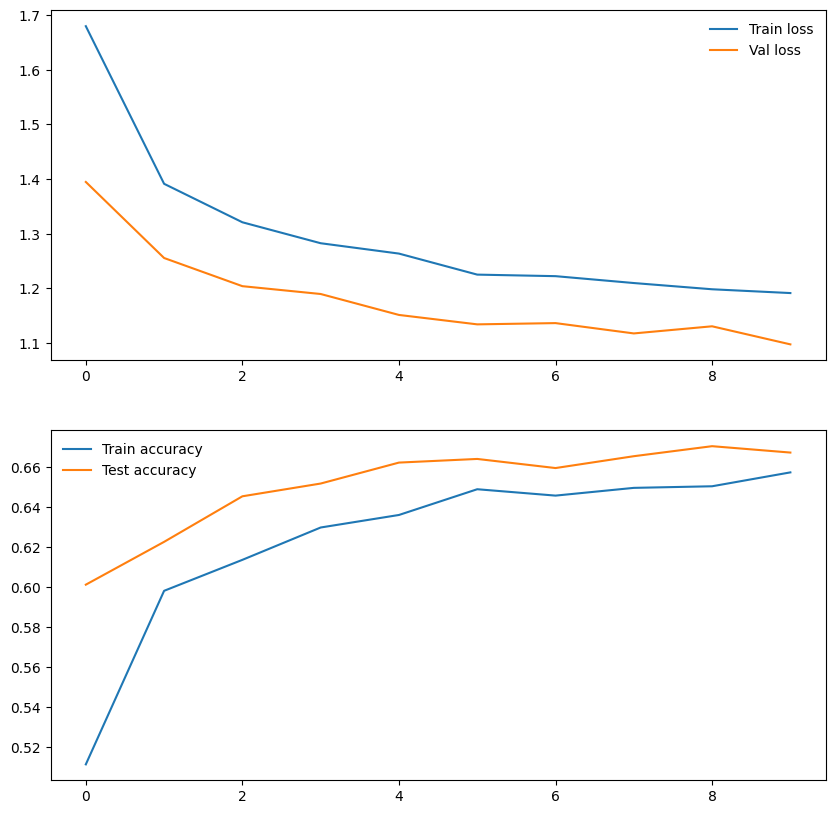

In [ ]:
train_test_info(history)

2.7 Измерить точность на тестовой выборке. Проверить работоспособность модели: прогнать несколько фамилий студентов группы через модели и проверить результат. Для каждой фамилии выводить 3 наиболее вероятных предсказания.

total accuracy: 0.667


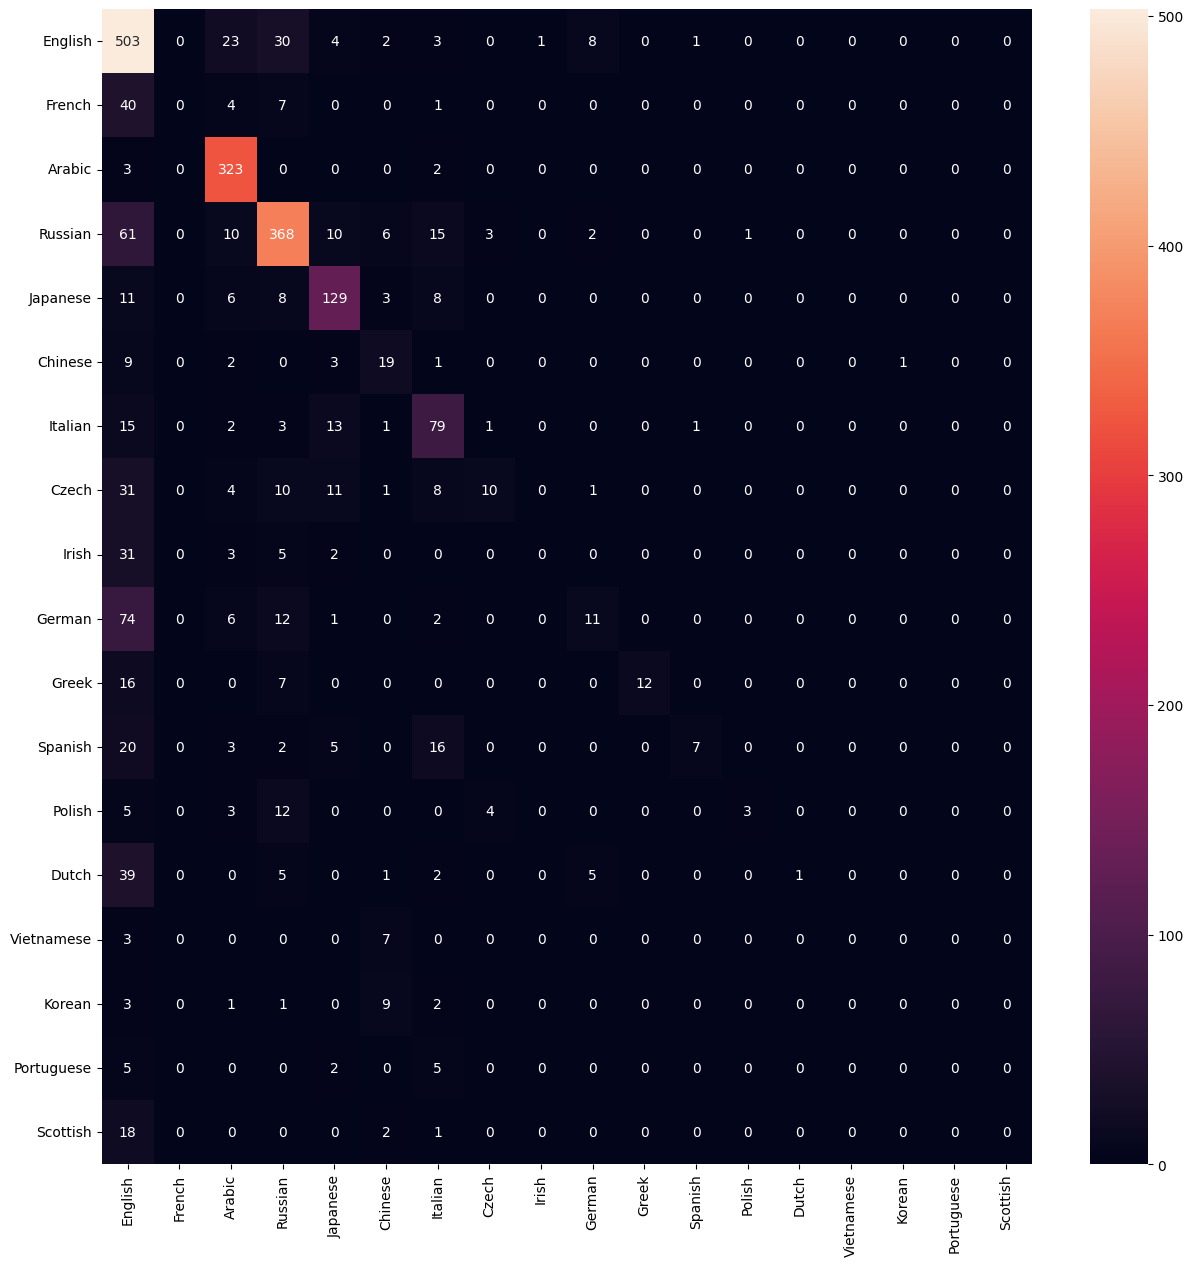

In [ ]:
conf_mat(unitarian_model, testloader, classes)

In [ ]:
surnames_list = ['Mikhailenko', 'Vaisberg', 'Sultonov', 'Hirasawa', 'Aluyeva', 'Ishmaev']
check_surnames(surnames_list, unitarian_model, train_dataset, classes)

Mikhailenko 	 PREDICTED: ['Russian', 'Japanese', 'Polish']
  Vaisberg 	 PREDICTED: ['Russian', 'English', 'German']
  Sultonov 	 PREDICTED: ['Russian', 'English', 'Czech']
  Hirasawa 	 PREDICTED: ['Japanese', 'Italian', 'Russian']
   Aluyeva 	 PREDICTED: ['Italian', 'Czech', 'Japanese']
   Ishmaev 	 PREDICTED: ['Russian', 'Czech', 'Japanese']


##### Токен представляется в виде вектора небольшой размерности (меньше, чем размер словаря) и модуль nn.Embedding обучается

In [ ]:
model = nn.Sequential(
    nn.Embedding(vocab.vocab_len, 128),

    nn.Conv1d(vocab.max_seq_len, 32, 3),
    nn.MaxPool1d(2),
    nn.LeakyReLU(0,1),

    nn.Conv1d(32, 64, 3),
    nn.MaxPool1d(2),
    nn.LeakyReLU(0,1),

    nn.Dropout(0.5),
    nn.Flatten(),
    nn.Linear(1920, 512),
    nn.Dropout(0.5),
    nn.LeakyReLU(0.1),
    nn.Linear(512, len(nationality_to_idx))
).to(device)

optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.001)
criterion = torch.nn.CrossEntropyLoss()

model(next(iter(trainloader))[0].to(device)).shape

torch.Size([1, 18])

In [ ]:
model, history = train_test(trainloader, testloader, model, criterion, optimizer, 10)

Epoch 1:
train loss: 0.681623
test: accuracy: 62.9%, val loss: 1.301905 

Epoch 5:
train loss: 0.458222
test: accuracy: 69.9%, val loss: 1.042321 

Epoch 10:
train loss: 0.304742
test: accuracy: 70.9%, val loss: 1.013412 



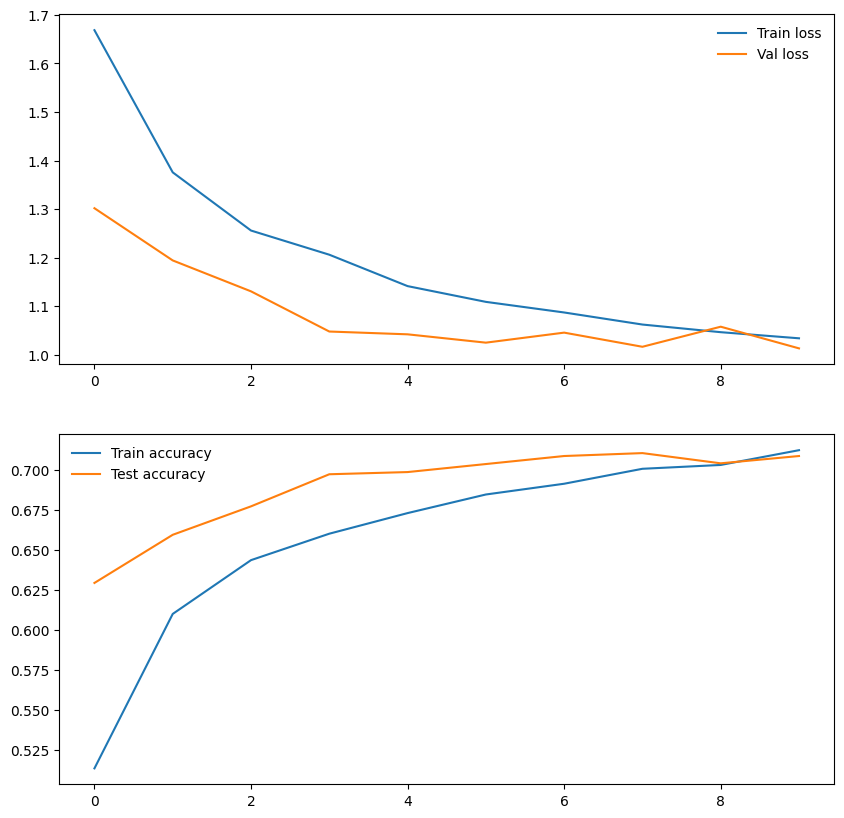

In [ ]:
train_test_info(history)

2.7 Измерить точность на тестовой выборке. Проверить работоспособность модели: прогнать несколько фамилий студентов группы через модели и проверить результат. Для каждой фамилии выводить 3 наиболее вероятных предсказания.

total accuracy: 0.709


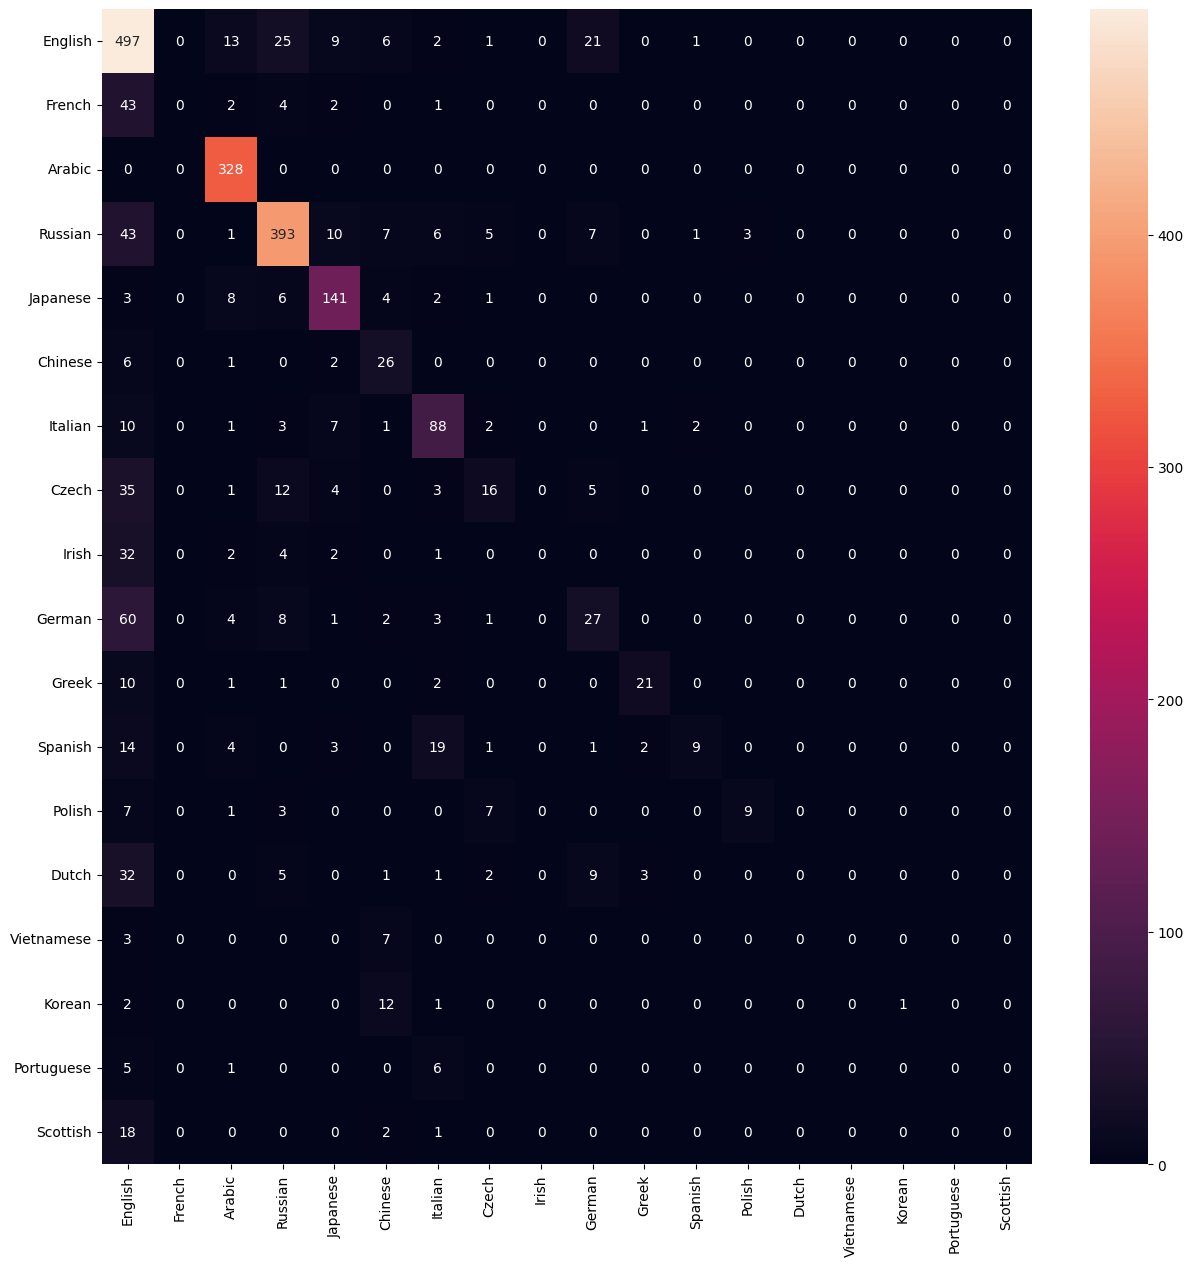

In [ ]:
conf_mat(model, testloader, classes)

In [ ]:
surnames_list = ['Mikhailenko', 'Vaisberg', 'Sultonov', 'Hirasawa', 'Aluyeva', 'Ishmaev']
check_surnames(surnames_list, model, train_dataset, classes)

Mikhailenko 	 PREDICTED: ['Russian', 'Polish', 'Czech']
  Vaisberg 	 PREDICTED: ['Russian', 'German', 'Czech']
  Sultonov 	 PREDICTED: ['Russian', 'Czech', 'Polish']
  Hirasawa 	 PREDICTED: ['Japanese', 'Greek', 'Italian']
   Aluyeva 	 PREDICTED: ['Czech', 'Russian', 'Polish']
   Ishmaev 	 PREDICTED: ['Russian', 'Arabic', 'Irish']


## 3. Классификация обзоров на фильмы (ConvNet)

Датасет: https://disk.yandex.ru/d/tdinpb0nN_Dsrg

2.1 Создайте набор данных на основе файлов polarity/positive_reviews.csv (положительные отзывы) и polarity/negative_reviews.csv (отрицательные отзывы). Разбейте на обучающую и тестовую выборку.
  * токен = __слово__
  * данные для обучения в датасете представляются в виде последовательности индексов токенов
  * словарь создается на основе _только_ обучающей выборки. Для корректной обработки ситуаций, когда в тестовой выборке встретится токен, который не хранится в словаре, добавьте в словарь специальный токен `<UNK>`
  * добавьте предобработку текста

2.2. Обучите классификатор.
  
  * Для преобразования последовательности индексов в последовательность векторов используйте `nn.Embedding`
    - подберите адекватную размерность вектора эмбеддинга:
    - модуль `nn.Embedding` обучается

  * Используйте одномерные свертки и пулинг (`nn.Conv1d`, `nn.MaxPool1d`)
    - обратите внимание, что `nn.Conv1d` ожидает на вход трехмерный тензор размерности `(batch, embedding_dim, seq_len)`


2.7 Измерить точность на тестовой выборке. Проверить работоспособность модели: придумать небольшой отзыв, прогнать его через модель и вывести номер предсказанного класса (сделать это для явно позитивного и явно негативного отзыва)
* Целевое значение accuracy на валидации - 70+%

2.1 Создайте набор данных на основе файлов polarity/positive_reviews.csv (положительные отзывы) и polarity/negative_reviews.csv (отрицательные отзывы). Разбейте на обучающую и тестовую выборку.
  * токен = __слово__
  * данные для обучения в датасете представляются в виде последовательности индексов токенов
  * словарь создается на основе _только_ обучающей выборки. Для корректной обработки ситуаций, когда в тестовой выборке встретится токен, который не хранится в словаре, добавьте в словарь специальный токен `<UNK>`
  * добавьте предобработку текста

In [ ]:
zf = zipfile.ZipFile('drive/MyDrive/datasets/polarity.zip')
for file in tqdm(zf.infolist()):
    zf.extract(file)

100%|██████████| 3/3 [00:00<00:00,  8.22it/s]


In [ ]:
with open('/content/polarity/positive_reviews.txt') as file:
    positive_reviews = file.readlines()

with open('/content/polarity/negative_reviews.txt') as file:
    negative_reviews = file.readlines()

positive_reviews = pd.DataFrame(positive_reviews, columns=['review'])
positive_reviews['rating'] = 1
negative_reviews = pd.DataFrame(negative_reviews, columns=['review'])
negative_reviews['rating'] = 0

reviews = pd.concat([positive_reviews, negative_reviews])
reviews.sample(5, random_state=20)

,review,rating
4597,you can fire a torpedo through some of clancy'...,0
4119,worth seeing just for weaver and lapaglia .\n,0
2674,reign of fire just might go down as one of the...,0
452,disturbing and brilliant documentary .\n,0
4537,shows moments of promise but ultimately succum...,1


In [ ]:
reviews.shape

(10662, 2)

In [ ]:
train_reviews, test_reviews = train_test_split(reviews, test_size=0.2)
train_reviews.head()

,review,rating
1750,don't be fooled by the impressive cast list - ...,1
2746,places a slightly believable love triangle in ...,1
2543,"unfortunately , heartbreak hospital wants to c...",1
712,ofrece una buena oportunidad de cultura ( aunq...,0
1496,what the film lacks in general focus it makes ...,0


In [ ]:
vocab_review = Vocab(train_reviews["review"])
len(vocab_review.idx_to_token)

16367

In [ ]:
train_dataset = ReviewsDataset(train_reviews["review"].to_numpy(), train_reviews["rating"].to_numpy(), vocab_review)
test_dataset = ReviewsDataset(test_reviews["review"].to_numpy(), test_reviews["rating"].to_numpy(), vocab_review)
trainloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=1, shuffle=True)
print(f'dataset size: {len(train_dataset)+len(test_dataset)}\n' +
      f'train size: {len(train_dataset)}\ntest size: {len(test_dataset)}')

dataset size: 10662
train size: 8529
test size: 2133


2.2. Обучите классификатор.
  
  * Для преобразования последовательности индексов в последовательность векторов используйте `nn.Embedding`
    - подберите адекватную размерность вектора эмбеддинга:
    - модуль `nn.Embedding` обучается

  * Используйте одномерные свертки и пулинг (`nn.Conv1d`, `nn.MaxPool1d`)
    - обратите внимание, что `nn.Conv1d` ожидает на вход трехмерный тензор размерности `(batch, embedding_dim, seq_len)`

In [ ]:
model = nn.Sequential(
    nn.Embedding(vocab_review.vocab_len + 1, 128),

    nn.Conv1d(vocab_review.max_seq_len, 32, 3, padding=1),
    nn.MaxPool1d(2),
    nn.LeakyReLU(0.1),
    nn.Dropout(0.25),

    nn.Conv1d(32, 64, 3, padding=1),
    nn.MaxPool1d(2),
    nn.LeakyReLU(0.1),
    nn.Dropout(0.25),

    nn.Flatten(),
    nn.Linear(2048, 1024),
    nn.LeakyReLU(),
    nn.Linear(1024, 2)
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

model(next(iter(trainloader))[0].to(device)).shape

torch.Size([1, 2])

In [ ]:
model, history = train_test(trainloader, testloader, model, criterion, optimizer, 15)

Epoch 1:
train loss: 0.610124
test: accuracy: 49.1%, val loss: 0.696573 

Epoch 5:
train loss: 0.151619
test: accuracy: 65.7%, val loss: 0.606703 

Epoch 10:
train loss: 0.016259
test: accuracy: 72.3%, val loss: 0.785137 

Epoch 15:
train loss: 0.000000
test: accuracy: 73.1%, val loss: 1.071901 



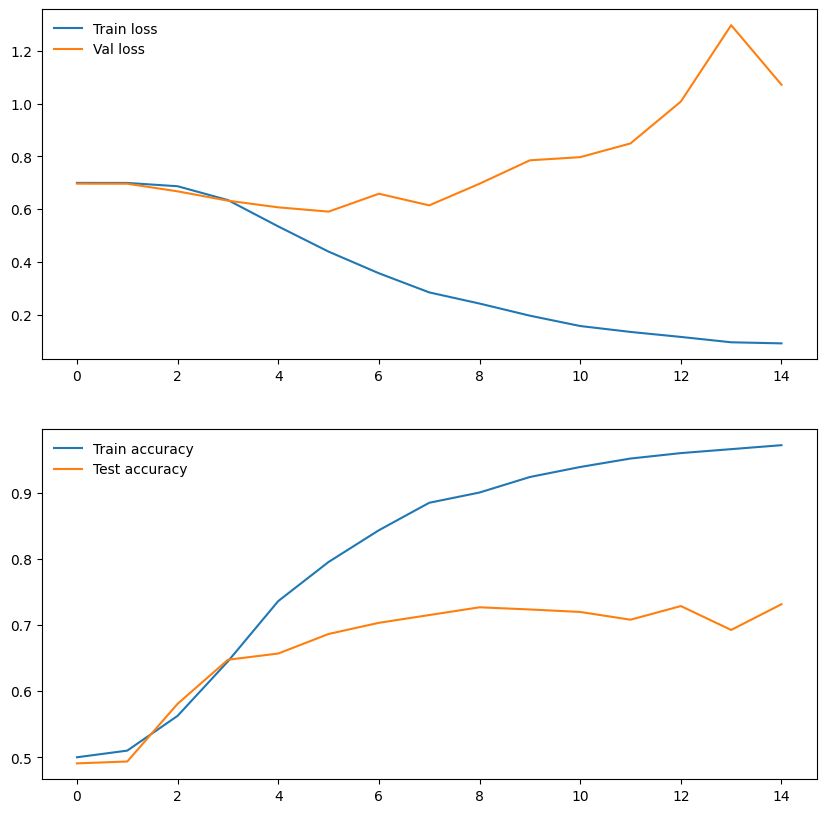

In [ ]:
train_test_info(history)

2.3 Измерить точность на тестовой выборке. Проверить работоспособность модели: придумать небольшой отзыв, прогнать его через модель и вывести номер предсказанного класса (сделать это для явно позитивного и явно негативного отзыва)
* Целевое значение accuracy на валидации - 70+%

total accuracy: 0.731


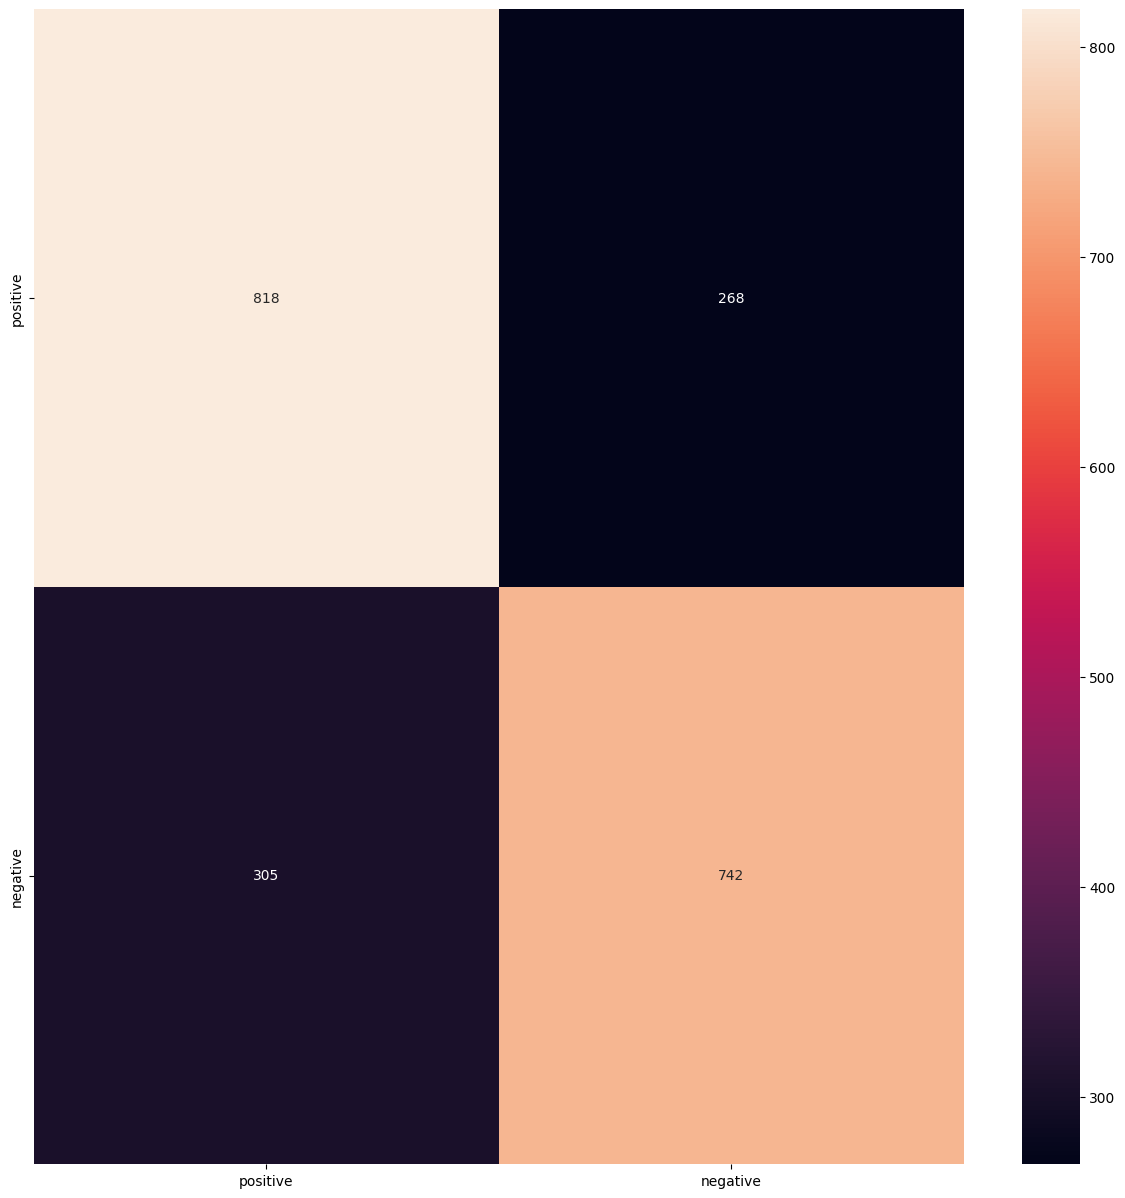

In [ ]:
conf_mat(model, testloader, ["positive", "negative"])

In [ ]:
reviews_list = ["It was amazing!! I really liked casting and my favorite scene is where John Wick almost died but he left alive",
                "Poor movie with awhul cast. I almost fell asleep while watching. Don't recommend"]

targets_dict = {1:"Positive", 0: "Negative"}
review_rating(reviews_list, targets_dict)


Review: 
It was amazing!! I really liked casting and my favorite scene is where John Wick almost died but he ..
True    : Positive
Predicts: tensor([1])
Predicts string: Positive

Review: 
Poor movie with awhul cast. I almost fell asleep while watching. Don't recommend..
True    : Negative
Predicts: tensor([0])
Predicts string: Negative

